In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Investigating Question #3

What are the predictive PU risk factors associated with demographic/injury, psychological, socio-environments, and protective/risk behaviors?

First we create a function to code BPrUlcers into binary format:

In [57]:
# Create a function to map bpr values to either 0 (no) or 1 (yes)
# Not needed ATM since we are just dropping values of 7 and 9

import numpy as np

def recode_bpr_ulcer(value):
  if value == 1:
    return 1
  elif value == 0:
    return 0
  else:
    raise ValueError("Invalid Value")

In [58]:
def recode_core_injury_severity(value):
        if value == "CoreHighC":
            return 1
        elif value == "CoreLowC":
            return 2
        elif value == "CorePara":
            return 3
        elif value == "CoreD":
            return 4
        elif value == "CoreVent":
            return 5
        else:
            raise ValueError("Invalid value")

Then we begin actually creating the multiple linear regression model including a variety of variables related to demographics, psychological, socio-environmental and behavioral factors.

In [59]:
import statsmodels.api as sm
import numpy as np;
import pandas as pd

merged_path = '/content/drive/MyDrive/Shepherd Center Project/merged.csv'
merged_df = pd.read_csv(merged_path)

risk_df = merged_df.copy()

# Drop all instances of 7 and 9 in the BPrUlcer (unknown and declined/Participant doesn't know responses)
risk_df = risk_df.drop(risk_df.loc[(risk_df['BPrUlcer'] == 7) | (risk_df['BPrUlcer'] == 9)].index)

# Drop rows with with nans
risk_df = risk_df.dropna(subset=['BPrUlcer', 'AInjAge', 'ASex', 'AHghtRhb', 'CoreInjurySeverity',\
    'AWghtRhb', 'ARace', 'AFmIncLv', 'AEducLvl', 'ABPHQSDS', 'AAnxiety', 'ARsTScr', 'BCHSocIn', 'ASATob', 'AAlcRate', ])

# Display current amount of PU present
display("Current Count of Ulcers Present vs No Ulcers = ", risk_df['BPrUlcer'].value_counts())
print()
print()

# Might need in future
risk_df.loc[:, 'BPrUlcer'] = risk_df['BPrUlcer'].apply(recode_bpr_ulcer)

# Apply the recoding function and fill in nans with mean
risk_df['CoreInjurySeverity'] = risk_df['CoreInjurySeverity'].apply(recode_core_injury_severity)
risk_df['CoreInjurySeverity'].fillna(risk_df['CoreInjurySeverity'].mean(), inplace=True)

# Define X and Y
y = risk_df['BPrUlcer']
X = risk_df[['AInjAge', 'ASex', 'AHghtRhb', 'AWghtRhb', 'CoreInjurySeverity', 'ARace', 'AFmIncLv', 'AEducLvl',\
    'ABPHQSDS', 'AAnxiety', 'BCHSocIn', 'ASATob', 'AAlcRate']]

# Fit the MLR model
risk_factors_model = sm.OLS(y, X).fit()

# Print summary
print(risk_factors_model.summary())

<ipython-input-59-0a7def90e5f0>:6: DtypeWarning: Columns (12,344,496,658,982) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv(merged_path)


'Current Count of Ulcers Present vs No Ulcers = '

BPrUlcer
0.0    15139
1.0     6260
Name: count, dtype: int64



                                 OLS Regression Results                                
Dep. Variable:               BPrUlcer   R-squared (uncentered):                   0.290
Model:                            OLS   Adj. R-squared (uncentered):              0.290
Method:                 Least Squares   F-statistic:                              673.3
Date:                Sun, 02 Jun 2024   Prob (F-statistic):                        0.00
Time:                        22:36:40   Log-Likelihood:                         -13542.
No. Observations:               21399   AIC:                                  2.711e+04
Df Residuals:                   21386   BIC:                                  2.721e+04
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

Let's check the VIF values for each variable and decide which have high levels of multicolinearity. Also going to cross validate to check the cv R-squared of the model.

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Dropped so far are 'ARsTScr' , 'ASATob', 'AWghtRhb',  'AAlcRate',  'AFmIncLv',  'ABPHQSDS'

# Calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Prepare the model
lin_reg = LinearRegression()

print()
# Perform cross-validation
scores = cross_val_score(lin_reg, X, y, cv=10, scoring='r2')
print("Cross-validated R-squared: ", np.mean(scores))


              Variable         VIF
0              AInjAge    7.030405
1                 ASex    8.355123
2             AHghtRhb   78.657364
3             AWghtRhb  102.167847
4   CoreInjurySeverity    7.725016
5                ARace    2.065648
6             AFmIncLv   40.735998
7             AEducLvl    6.158400
8             ABPHQSDS  137.919231
9             AAnxiety   46.732554
10            BCHSocIn    1.486660
11              ASATob  149.952848
12            AAlcRate   65.975693

Cross-validated R-squared:  0.009069200034129787


There's many variables with very high VIF values which indicate multiclinearity and a lack of stability with these current variables. Let's create a residuals plot to see how good of a fit our model is visually.

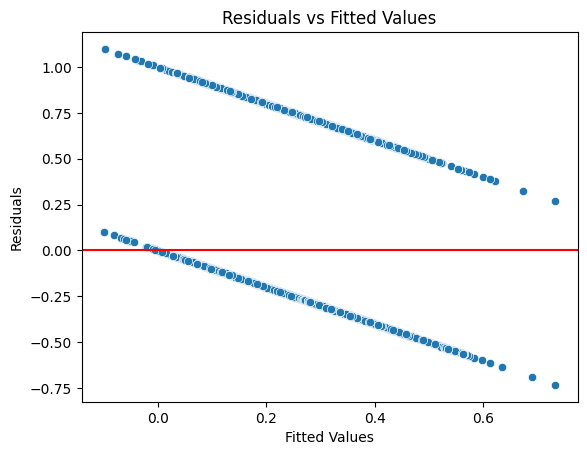

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = risk_factors_model.resid
fitted_values = risk_factors_model.predict()

sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(y=0, color='red')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

We can see based on the tight fit of all the points and clear negative linear relationship that our current model is not an ideal fit for the data. Ideally we would like there to be less of a pattern so we could meet the conditions of linearity and independence.

Let's create an XGBoost model in order to see which features it deems most important since we have such a variety of variables and VIF/multicolinearity issues with our multiple linear regression.

In [62]:
import xgboost as xgb

# Create an XGBoost model
model = xgb.XGBClassifier(objective="binary:logistic", seed=42)

# Train the model
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Evaluate the model
accuracy = np.mean(y_pred == y)
print("Accuracy:", accuracy)


Accuracy: 0.7923267442403851


In [63]:
# Get feature importance
importances = model.feature_importances_

# Create a dataframe with feature importance
feature_importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
})

# Sort the dataframe by importance
feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False)

# Print the top 5 most important features
print(feature_importance_df)


               feature  importance
4   CoreInjurySeverity    0.302294
10            BCHSocIn    0.068201
11              ASATob    0.063521
5                ARace    0.062606
7             AEducLvl    0.060057
0              AInjAge    0.059153
12            AAlcRate    0.058190
3             AWghtRhb    0.057433
6             AFmIncLv    0.055654
8             ABPHQSDS    0.054453
2             AHghtRhb    0.054181
9             AAnxiety    0.053575
1                 ASex    0.050682



The XGboost model achieved an accuracy of 0.79 on the dataset. This means that the model correctly predicted the presence or absence of pressure ulcers in 79% of the cases.

CoreInjurySeverity is clearly the most influential variable in our model, which makes sense given the nature of pressure ulcers.

In [64]:
import pickle

# Save the model to a file
with open('/content/drive/MyDrive/Shepherd Center Project/risk_factors_model.pkl', 'wb') as f:
  pickle.dump(model, f)

# Load the model from the file
with open('/content/drive/MyDrive/Shepherd Center Project/risk_factors_model.pkl', 'rb') as f:
  loaded_model = pickle.load(f)


In [65]:
with open('/content/drive/MyDrive/Shepherd Center Project/risk_factors_model.pkl', 'rb') as f:
  model = pickle.load(f)
  # Get feature importance
  importances = model.feature_importances_

# Create a dataframe with feature importance
feature_importance_df_pickle = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
})

feature_importance_df_pickle = feature_importance_df_pickle.sort_values(by="importance", ascending=False)

print(feature_importance_df_pickle)


               feature  importance
4   CoreInjurySeverity    0.302294
10            BCHSocIn    0.068201
11              ASATob    0.063521
5                ARace    0.062606
7             AEducLvl    0.060057
0              AInjAge    0.059153
12            AAlcRate    0.058190
3             AWghtRhb    0.057433
6             AFmIncLv    0.055654
8             ABPHQSDS    0.054453
2             AHghtRhb    0.054181
9             AAnxiety    0.053575
1                 ASex    0.050682


We can see that CoreInjurySeverity is by far the most important feature according to XGBoost, which I found to be interesting after the linear regression results. I decided to run another multiple linear regression with just the top 5 features returned from our XGBoost exploration.

In [78]:
# Define X and Y
y = risk_df['BPrUlcer']
X = risk_df[['CoreInjurySeverity', 'BCHSocIn', 'ASATob', 'ARace', 'AEducLvl', 'AInjAge', 'AHghtRhb']]

# Fit the MLR model
risk_factors_model_top_7 = sm.OLS(y, X).fit()

# Print summary
print(risk_factors_model_top_7.summary())


                                 OLS Regression Results                                
Dep. Variable:               BPrUlcer   R-squared (uncentered):                   0.284
Model:                            OLS   Adj. R-squared (uncentered):              0.284
Method:                 Least Squares   F-statistic:                              1213.
Date:                Sun, 02 Jun 2024   Prob (F-statistic):                        0.00
Time:                        23:22:52   Log-Likelihood:                         -13636.
No. Observations:               21399   AIC:                                  2.729e+04
Df Residuals:                   21392   BIC:                                  2.734e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [80]:
# Calculate VIF for each explanatory variable
vif_top_7 = pd.DataFrame()
vif_top_7["Variable"] = X.columns
vif_top_7["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_top_7)

# Prepare the model
lin_reg_top_7 = LinearRegression()

# Perform cross-validation
scores_top_7 = cross_val_score(lin_reg_top_7, X, y, cv=10, scoring='r2')
print("Cross-validated R-squared: ", np.mean(scores_top_7))

             Variable       VIF
0  CoreInjurySeverity  7.187373
1            BCHSocIn  1.472634
2              ASATob  9.457122
3               ARace  2.031075
4            AEducLvl  5.726650
5             AInjAge  6.211668
6            AHghtRhb  3.164900
Cross-validated R-squared:  0.008257522863520272


Multicolinearity is certainly reduced due to the lower number of features, however R^2 is still quite weak and so is CV R^2.

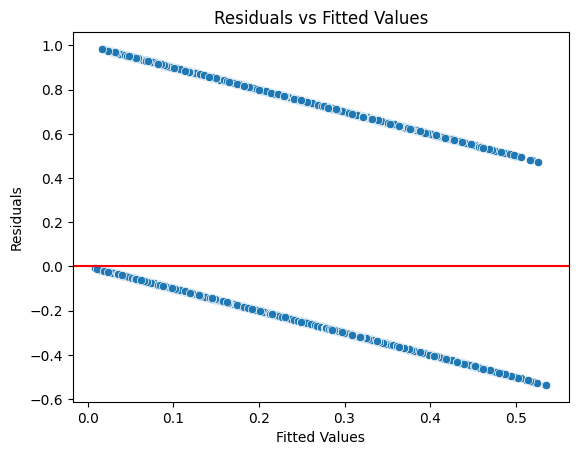

In [81]:
# Create a residuals plot
residuals_top_7 = risk_factors_model_top_7.resid
fitted_values_top_7 = risk_factors_model_top_7.predict()

sns.scatterplot(x=fitted_values_top_7, y=residuals_top_7)
plt.axhline(y=0, color='red')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()


Residuals plot looks slighty better, but still very patterned and indicative of a poor fit.

In [84]:
# Define X and Y
y = risk_df['BPrUlcer']
X = risk_df[['CoreInjurySeverity', 'BCHSocIn', 'ASATob', 'ARace', 'AEducLvl', 'AInjAge', 'AHghtRhb']]

# Fit a Random Forest model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X, y)

# Evaluate the model
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=10)
print("Cross-validation accuracy:", np.mean(scores))

# Get feature importance
importances = model.feature_importances_

# Create a dataframe with feature importance
feature_importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
})

# Sort the dataframe by importance
feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False)

print(feature_importance_df)

Cross-validation accuracy: 0.6503577092972959
              feature  importance
5             AInjAge    0.337066
1            BCHSocIn    0.252751
6            AHghtRhb    0.149462
0  CoreInjurySeverity    0.102089
4            AEducLvl    0.085961
3               ARace    0.047720
2              ASATob    0.024950


Our accuracy was greatly improved in comparison to the multiple linear regression, likely due to the wider breadth of data that random forest can account for. We were also able to see a reoccuring trend in the most important features found through the 3 types of models (MLR, XGBoost, and Random Forest). Injury age, societal inclusion levels, height, and core injury severity all appeared to be some of the most important factors in predicting the presence of pressure ulcers. This would make sense when analyzing the nature of these features since many of them relate to mobility, overall body composition, and injury levels which are all very important when it comes to pressure ulcers.